In [1]:
import shutil
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random

In [2]:
# Định nghĩa kích thước ảnh
img_width, img_height = 96, 96

# Tạo mô hình
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), input_shape=(img_height, img_width, 1)),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3)),
        MaxPooling2D((2, 2)),
        
        Conv2D(256, (3, 3)),
        MaxPooling2D((2, 2)),
        
        GlobalAveragePooling2D(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(600, activation='softmax')  # Lớp đầu ra cho phân loại
    ])
    return model

# Tải trọng số mô hình
model = create_model()
model.load_weights('fingerprint_model_weights1.weights.h5')

d:\Project\Th-c-t-p-t-t-nghi-p\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Hàm tiền xử lý ảnh
def preprocess_images(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (img_width, img_height))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)  # Thêm chiều cho ảnh
    return img

# Hàm tìm nhãn tốt nhất cho từng ảnh
def verify_fingerprint(fingerprint_image_path, model, features, labels):
    # Tiền xử lý ảnh đầu vào
    input_image = preprocess_images(fingerprint_image_path)
    input_image = np.expand_dims(input_image, axis=0)

    # Trích xuất đặc trưng
    input_feature = model.predict(input_image).flatten()
    # Tính toán độ tương đồng cosine
    similarities = cosine_similarity([input_feature], features)

    # Tìm đặc trưng có độ tương đồng cao nhất
    best_match_index = np.argmax(similarities)
    best_match_label = labels[best_match_index]

    return best_match_label, similarities[0][best_match_index]

# Hàm tải và xử lý các ảnh chưa được huấn luyện
def load_untrained_images(data_paths, model, features, labels):
    similarities = []
    best_labels = []
    i = 0
    for path in data_paths:
        for file in os.listdir(path):
            if file.endswith(".BMP"):
                print(f"{i} : {total}")
                i+=1
                img_path = os.path.join(path, file)
                best_label, similarity = verify_fingerprint(img_path, model, features, labels)
                similarities.append(similarity)
                best_labels.append(best_label)

    return similarities, best_labels

def calculate_metrics(similarities, best_labels, actual_labels, thresholds):
    metrics = {
        "threshold": [],
        "accuracy": [],
        "sensitivity": [],
        "specificity": [],
        "precision": [],
        "f1_score": []
    }

    for threshold in thresholds:
        tp = fp = tn = fn = 0
        
        for i in range(len(similarities)):
            if similarities[i] >= threshold:
                if best_labels[i] == actual_labels[i]:  # True Positive
                    tp += 1
                else:  # False Positive
                    fp += 1
            else:
                if best_labels[i] == actual_labels[i]:  # False Negative
                    fn += 1
                else:  # True Negative
                    tn += 1

        # Tính toán các chỉ số
        accuracy = (tp + tn) / len(similarities)
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Độ nhạy
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Độ đặc hiệu
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0  # Độ chính xác dương tính
        f1 = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0  # F1 Score

        # Lưu các chỉ số vào metrics
        metrics["threshold"].append(threshold)
        metrics["accuracy"].append(accuracy)
        metrics["sensitivity"].append(sensitivity)
        metrics["specificity"].append(specificity)
        metrics["precision"].append(precision)
        metrics["f1_score"].append(f1)

    return metrics

def find_effective_thresholds(similarities, best_labels, actual_labels):
    thresholds = np.arange(0.9, 1.01, 0.01)  # Ngưỡng từ 0.5 đến 1 với bước nhảy 0.05
    metrics = calculate_metrics(similarities, best_labels, actual_labels, thresholds)
    
    return metrics

# Đường dẫn tới folder imgnotrain
data_paths = [
    "Data\SOCOFing\SOCOFing\Altered\Altered-Medium",
    "Data\SOCOFing\SOCOFing\Altered\Altered-Hard",
]
features = np.load('fingerprint_features_by_model_weight1.npy')  # Tải đặc trưng đã lưu
labels = np.load('fingerprint_labels_by_model_weight1.npy')  # Tải nhãn đã lưu

# Tạo danh sách nhãn thực tế từ tên tệp (giả sử tên tệp có định dạng "0__image1.BMP")
total = 0
actual_labels = []
for path in data_paths:
        for file in os.listdir(path):
            if file.endswith(".BMP"):
                total+=1
                label = int(file.split("__")[0]) - 1  # Lấy nhãn từ tên tệp
                actual_labels.append(label)

# Tải và xử lý các hình ảnh chưa được huấn luyện
similarities, best_labels = load_untrained_images(data_paths, model, features, labels)
if len(similarities) != len(best_labels) or len(best_labels) != len(actual_labels):
    print("Lỗi: Các danh sách không có cùng chiều dài.")
else:
    # Tìm ngưỡng hiệu quả
    metrics = find_effective_thresholds(similarities, best_labels, actual_labels)

     # Vẽ biểu đồ cho các chỉ số
    plt.figure(figsize=(12, 8))
    plt.plot(metrics["threshold"], metrics["accuracy"], label='Độ chính xác', marker='o')
    plt.plot(metrics["threshold"], metrics["sensitivity"], label='Độ nhạy', marker='o')
    plt.plot(metrics["threshold"], metrics["specificity"], label='Độ đặc hiệu', marker='o')
    plt.plot(metrics["threshold"], metrics["precision"], label='Độ chính xác dương tính', marker='o')
    plt.plot(metrics["threshold"], metrics["f1_score"], label='F1 Score', marker='o')
    
    plt.xlabel('Ngưỡng')
    plt.ylabel('Giá trị')
    plt.title('Đánh giá mô hình theo các ngưỡng')
    plt.legend()
    plt.grid()
    plt.xticks(np.arange(0.9, 1.05, 0.01))
    plt.tight_layout()  # Đảm bảo không có chồng chéo giữa các biểu đồ
    plt.show()

0 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
5 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
6 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
8 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
9 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
10 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
11 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
12 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
13 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
14 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
15 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
16 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
17 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
18 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
19 : 31339
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
20 : 31339
1/1 ━━━━━━━━━━━━━━━

KeyboardInterrupt: 

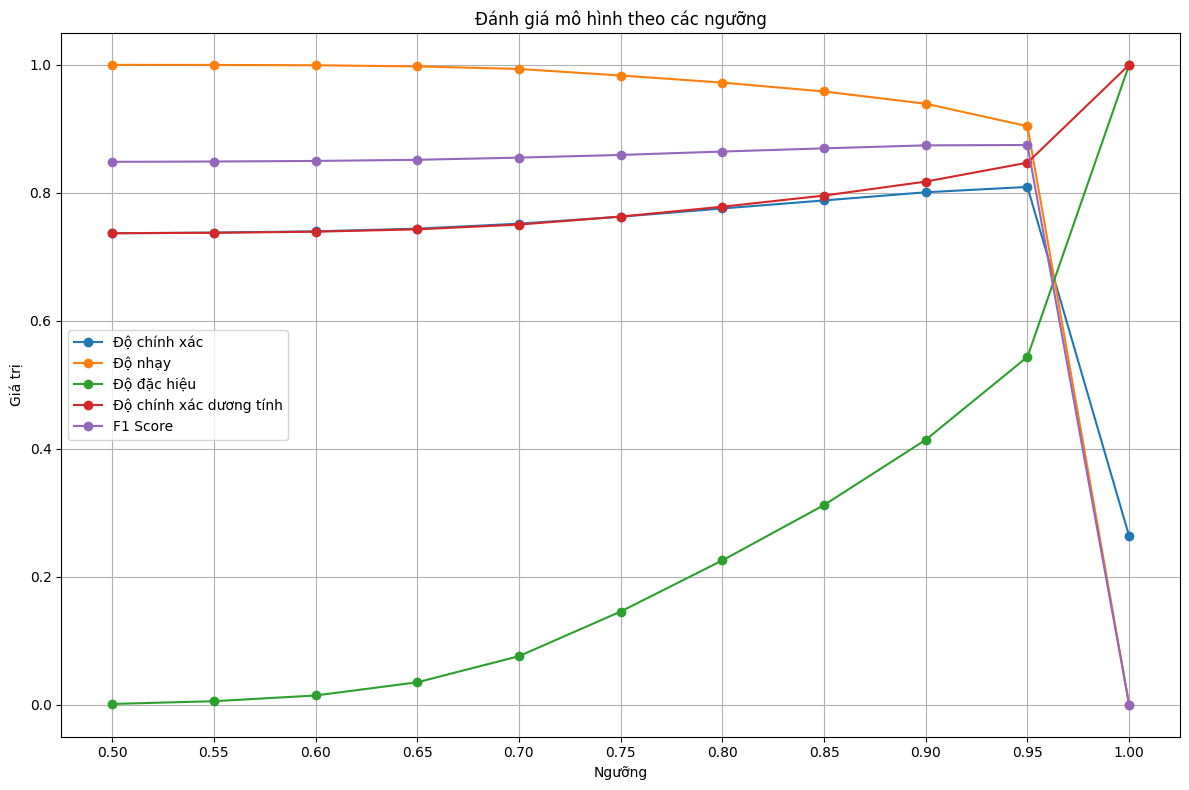

In [4]:
metrics = find_effective_thresholds(similarities, best_labels, actual_labels)

# Vẽ biểu đồ cho các chỉ số
plt.figure(figsize=(12, 8))
plt.plot(metrics["threshold"], metrics["accuracy"], label='Độ chính xác', marker='o')
plt.plot(metrics["threshold"], metrics["sensitivity"], label='Độ nhạy', marker='o')
plt.plot(metrics["threshold"], metrics["specificity"], label='Độ đặc hiệu', marker='o')
plt.plot(metrics["threshold"], metrics["precision"], label='Độ chính xác dương tính', marker='o')
plt.plot(metrics["threshold"], metrics["f1_score"], label='F1 Score', marker='o')

plt.xlabel('Ngưỡng')
plt.ylabel('Giá trị')
plt.title('Đánh giá mô hình theo các ngưỡng')
plt.legend()
plt.grid()
plt.xticks(np.arange(0.5, 1.05, 0.05))
plt.tight_layout()  # Đảm bảo không có chồng chéo giữa các biểu đồ
plt.show()

In [7]:
# Tìm ngưỡng tối ưu cho các mô hình phân loại là một phần quan trọng trong việc cải thiện hiệu suất của mô hình. Ngưỡng tối ưu giúp bạn cân bằng giữa các chỉ số như độ chính xác, độ nhạy và độ đặc hiệu. Dưới đây là một số phương pháp và công thức phổ biến để tìm ngưỡng tối ưu:

# 1. Ngưỡng tối ưu dựa trên F1 Score
# F1 Score là chỉ số tốt để đánh giá hiệu suất của mô hình, đặc biệt trong các bài toán phân loại không cân bằng. Bạn có thể tìm ngưỡng tối ưu bằng cách tối đa hóa F1 Score.

# Cách thực hiện:

# Tính toán F1 Score cho mỗi ngưỡng trong khoảng từ 0 đến 1.
# Chọn ngưỡng mà tại đó F1 Score đạt giá trị cao nhất.

best_threshold = metrics["threshold"][np.argmax(metrics["f1_score"])]
print(f"Ngưỡng tối ưu dựa trên F1 Score: {best_threshold}")

Ngưỡng tối ưu dựa trên F1 Score: 0.9500000000000004
